In [57]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
import tensorflow as tf

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/442100110323_hourly_weather_features.csv')
df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
df.set_index('READ_DATE', inplace=True)
df

,KWH_EXP,Tavg,RH_avg,RR,ss,lag_1,lag_6,lag_12,lag_24,rolling_mean_1,...,season_cos,dayofweek_sin,dayofweek_cos,weekofyear_sin,weekofyear_cos,dayofyear_sin,dayofyear_cos,trend,seasonal,residual
READ_DATE,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,2.402650,25.7,96.0,12.9,7.5,0.000000,0.000000,0.000000,0.000000,2.402650,...,1.0,0.866025,0.5,0.120537,0.992709,0.017166,0.999853,7.932104,-0.209330,0.000425
2019-01-01 01:00:00,2.408348,25.7,96.0,12.9,7.5,2.402650,0.000000,0.000000,0.000000,2.408348,...,1.0,0.866025,0.5,0.120537,0.992709,0.017166,0.999853,7.932104,-0.090785,0.000425
2019-01-01 02:00:00,2.406840,25.7,96.0,12.9,7.5,2.408348,0.000000,0.000000,0.000000,2.406840,...,1.0,0.866025,0.5,0.120537,0.992709,0.017166,0.999853,7.932104,0.082446,0.000425
2019-01-01 03:00:00,2.256511,25.7,96.0,12.9,7.5,2.406840,0.000000,0.000000,0.000000,2.256511,...,1.0,0.866025,0.5,0.120537,0.992709,0.017166,0.999853,7.932104,0.077927,0.000425
2019-01-01 04:00:00,2.065598,25.7,96.0,12.9,7.5,2.256511,0.000000,0.000000,0.000000,2.065598,...,1.0,0.866025,0.5,0.120537,0.992709,0.017166,0.999853,7.932104,0.115159,0.000425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 19:00:00,65.205495,29.8,68.0,0.0,10.8,65.268262,73.044454,75.646947,60.058114,65.205495,...,-1.0,-0.866025,-0.5,0.464723,-0.885456,0.507415,-0.861702,7.932104,-0.086264,0.000425
2024-05-31 20:00:00,65.520523,29.8,68.0,0.0,10.8,65.205495,71.052517,76.229854,63.987306,65.520523,...,-1.0,-0.866025,-0.5,0.464723,-0.885456,0.507415,-0.861702,7.932104,0.074562,0.000425
2024-05-31 21:00:00,66.389436,29.8,68.0,0.0,10.8,65.520523,68.469683,73.488070,65.499925,66.389436,...,-1.0,-0.866025,-0.5,0.464723,-0.885456,0.507415,-0.861702,7.932104,0.096503,0.000425


In [60]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':]

In [61]:
scaler = StandardScaler()

In [62]:
# scaling data train
train_scaled = scaler.fit_transform(train)
train_scaled = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
train_scaled



,KWH_EXP,Tavg,RH_avg,RR,ss,lag_1,lag_6,lag_12,lag_24,rolling_mean_1,...,season_cos,dayofweek_sin,dayofweek_cos,weekofyear_sin,weekofyear_cos,dayofyear_sin,dayofyear_cos,trend,seasonal,residual
READ_DATE,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,-0.921600,-1.510370,2.072502,0.764111,-0.170246,-1.209863,-1.209763,-1.209709,-1.209528,-0.921600,...,1.189486,1.321971,0.482817,0.170046,1.396816,0.024252,1.418372,-0.279837,-1.814674,0.000119
2019-01-01 01:00:00,-0.920917,-1.510370,2.072502,0.764111,-0.170246,-0.921581,-1.209763,-1.209709,-1.209528,-0.920917,...,1.189486,1.321971,0.482817,0.170046,1.396816,0.024252,1.418372,-0.279837,-0.787017,0.000119
2019-01-01 02:00:00,-0.921098,-1.510370,2.072502,0.764111,-0.170246,-0.920897,-1.209763,-1.209709,-1.209528,-0.921098,...,1.189486,1.321971,0.482817,0.170046,1.396816,0.024252,1.418372,-0.279837,0.714711,0.000119
2019-01-01 03:00:00,-0.939135,-1.510370,2.072502,0.764111,-0.170246,-0.921078,-1.209763,-1.209709,-1.209528,-0.939135,...,1.189486,1.321971,0.482817,0.170046,1.396816,0.024252,1.418372,-0.279837,0.675535,0.000119
2019-01-01 04:00:00,-0.962042,-1.510370,2.072502,0.764111,-0.170246,-0.939116,-1.209763,-1.209709,-1.209528,-0.962042,...,1.189486,1.321971,0.482817,0.170046,1.396816,0.024252,1.418372,-0.279837,0.998292,0.000119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,-0.891599,0.644466,0.566106,2.975064,-2.743848,-1.003674,-1.077062,-1.093269,-0.973890,-0.891599,...,1.189486,-1.321971,0.482817,-0.000701,1.407110,-0.024252,1.418372,-1.071708,-0.826064,0.262614
2022-12-31 20:00:00,-0.870325,0.644466,0.566106,2.975064,-2.743848,-0.891580,-1.074522,-1.082838,-0.872157,-0.870325,...,1.189486,-1.321971,0.482817,-0.000701,1.407110,-0.024252,1.418372,-1.079512,0.664686,0.281460
2022-12-31 21:00:00,-0.870764,0.644466,0.566106,2.975064,-2.743848,-0.870306,-1.072373,-1.069823,-0.877877,-0.870764,...,1.189486,-1.321971,0.482817,-0.000701,1.407110,-0.024252,1.418372,-1.083304,1.300663,0.267678


In [63]:
# scaling data test
test_scaled = scaler.transform(test)
test_scaled = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
test_scaled

,KWH_EXP,Tavg,RH_avg,RR,ss,lag_1,lag_6,lag_12,lag_24,rolling_mean_1,...,season_cos,dayofweek_sin,dayofweek_cos,weekofyear_sin,weekofyear_cos,dayofyear_sin,dayofyear_cos,trend,seasonal,residual
READ_DATE,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,-0.857399,0.082335,0.797859,0.266869,-0.204561,-0.865887,-1.003584,-1.079294,-0.874517,-0.857399,...,1.189486,-4.116180e-16,1.156547,-0.000701,1.407110,0.024252,1.418372,-1.083923,-1.232319,0.385328
2023-01-01 01:00:00,-0.865644,0.082335,0.797859,0.266869,-0.204561,-0.857381,-0.891495,-1.077011,-0.863761,-0.865644,...,1.189486,-4.116180e-16,1.156547,-0.000701,1.407110,0.024252,1.418372,-1.084548,-0.672264,0.348304
2023-01-01 02:00:00,-0.872474,0.082335,0.797859,0.266869,-0.204561,-0.865625,-0.870222,-1.074471,-0.878321,-0.872474,...,1.189486,-4.116180e-16,1.156547,-0.000701,1.407110,0.024252,1.418372,-1.085061,0.890885,0.281089
2023-01-01 03:00:00,-0.869078,0.082335,0.797859,0.266869,-0.204561,-0.872455,-0.870662,-1.072322,-0.887253,-0.869078,...,1.189486,-4.116180e-16,1.156547,-0.000701,1.407110,0.024252,1.418372,-1.084353,0.758190,0.292081
2023-01-01 04:00:00,-0.871847,0.082335,0.797859,0.266869,-0.204561,-0.869059,-0.876746,-1.076355,-0.872172,-0.871847,...,1.189486,-4.116180e-16,1.156547,-0.000701,1.407110,0.024252,1.418372,-1.080306,0.561284,0.283001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 19:00:00,6.613860,2.330858,-1.172043,-0.381322,0.962138,6.621333,7.554053,7.866116,5.995402,6.613860,...,-0.840700,-1.321971e+00,-0.864643,0.657605,-1.254965,0.716858,-1.216982,-0.279837,-0.747824,0.000119
2024-05-31 20:00:00,6.651659,2.330858,-1.172043,-0.381322,0.962138,6.613802,7.315062,7.936051,6.466771,6.651659,...,-0.840700,-1.321971e+00,-0.864643,0.657605,-1.254965,0.716858,-1.216982,-0.279837,0.646364,0.000119
2024-05-31 21:00:00,6.755916,2.330858,-1.172043,-0.381322,0.962138,6.651601,7.005176,7.607103,6.648234,6.755916,...,-0.840700,-1.321971e+00,-0.864643,0.657605,-1.254965,0.716858,-1.216982,-0.279837,0.836572,0.000119


In [64]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [65]:
# jika datanya diambil setiap 15 menit, maka time_steps = 96 berarti 24 jam

time_steps = 96
# reshape ke bentuk 3D array
X_train, y_train = create_dataset(train_scaled, train_scaled['KWH_EXP'], time_steps)
X_test, y_test = create_dataset(test_scaled, test_scaled['KWH_EXP'], time_steps)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(34968, 96, 56) (34968,)
(12312, 96, 56) (12312,)


In [66]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [67]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional)      │ (None, 96, 256)             │         189,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 353,921 (1.35 MB)

 Trainable params: 353,921 (1.35 MB)

 Non-trainable params: 0 (0.00 B)


SPLITTING DATA RATIO :

* Train data : tahun 2019-2022 akhir
* Test data : tahun 2023-ujung data
* Validation data : diambil 10% dari training data

In [68]:
#  callback
# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
# learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# training
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 0.6126 - val_loss: 0.3961 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.3988 - val_loss: 0.2373 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.2421 - val_loss: 0.1162 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.1622 - val_loss: 0.1416 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.1215 - val_loss: 0.0408 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.1555 - val_loss: 0.0579 - learning_rate: 9.0484e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.1330 - val_loss: 0.0380 - learning_rate: 8.1873e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.1062 - val_loss: 0.0333 - learning_rate: 7.4082e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.1093 - val_loss: 0.0453 - learning_rate: 6.703

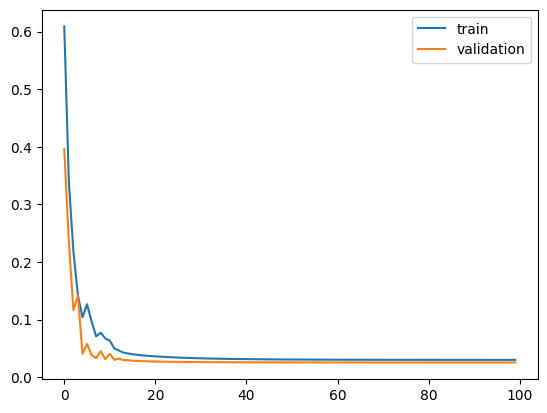

In [69]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot   (history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [70]:
# predict

y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)


385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


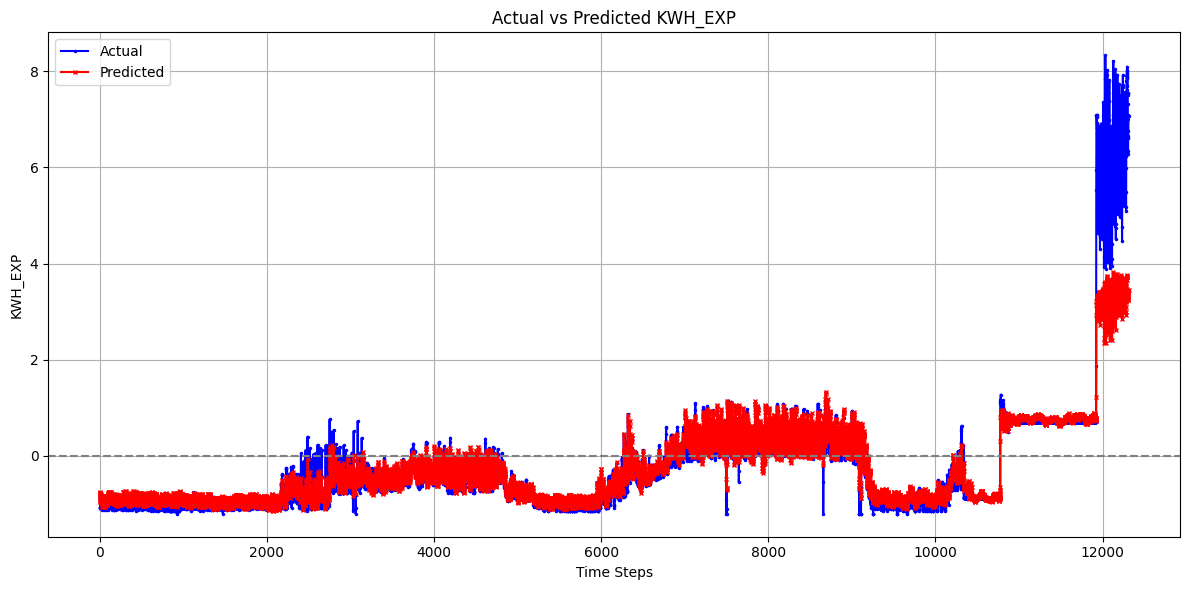

In [71]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Garis referensi
plt.title('Actual vs Predicted KWH_EXP')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [72]:
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.3269266252109784
MAE: 0.18432988896932445
R2: 0.8198619063525725
MAPE: 1.0621898744293694


# ATTENTION

In [73]:
# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        attention_weights = tf.nn.softmax(tf.matmul(inputs, inputs, transpose_b=True), axis=-1)
        context_vector = tf.matmul(attention_weights, inputs)
        return context_vector

# Model definition with Attention
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)
x = LSTM(units=128, return_sequences=True)(inputs)
x = AttentionLayer()(x)
x = LSTM(units=64, return_sequences=False)(x)
outputs = Dense(units=1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 96, 56)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 96, 128)             │          94,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_4 (AttentionLayer)   │ (None, 96, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 144,193 (563.25 KB)

 Trainable params: 144,193 (563.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.5813 - val_loss: 0.1436 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.3039 - val_loss: 0.0992 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.2506 - val_loss: 0.0986 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.2050 - val_loss: 0.1502 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1577 - val_loss: 0.0699 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1307 - val_loss: 0.0644 - learning_rate: 9.0484e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1087 - val_loss: 0.0648 - learning_rate: 8.1873e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1009 - val_loss: 0.0628 - learning_rate: 7.4082e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1062 - val_loss: 0.0596 - learning_rate: 6.703

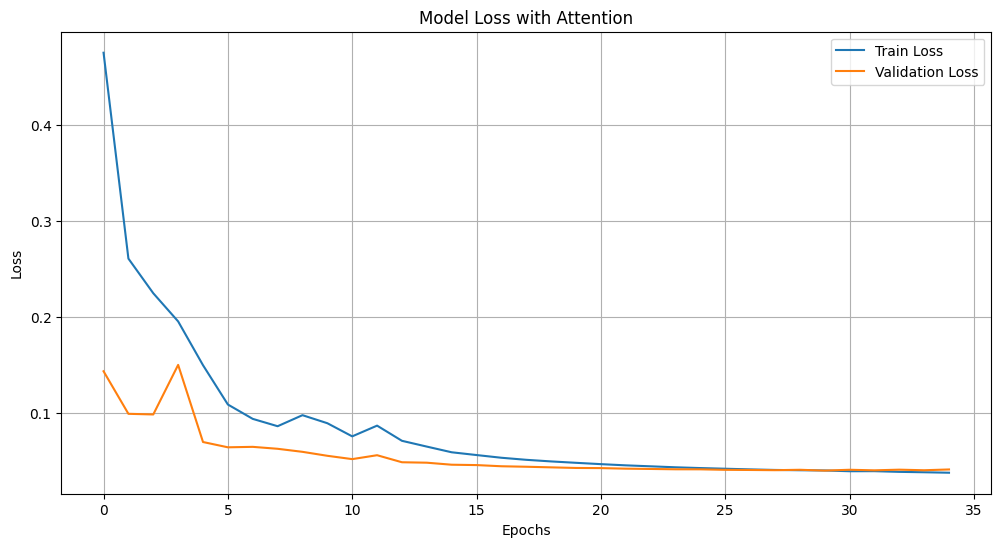

385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [74]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

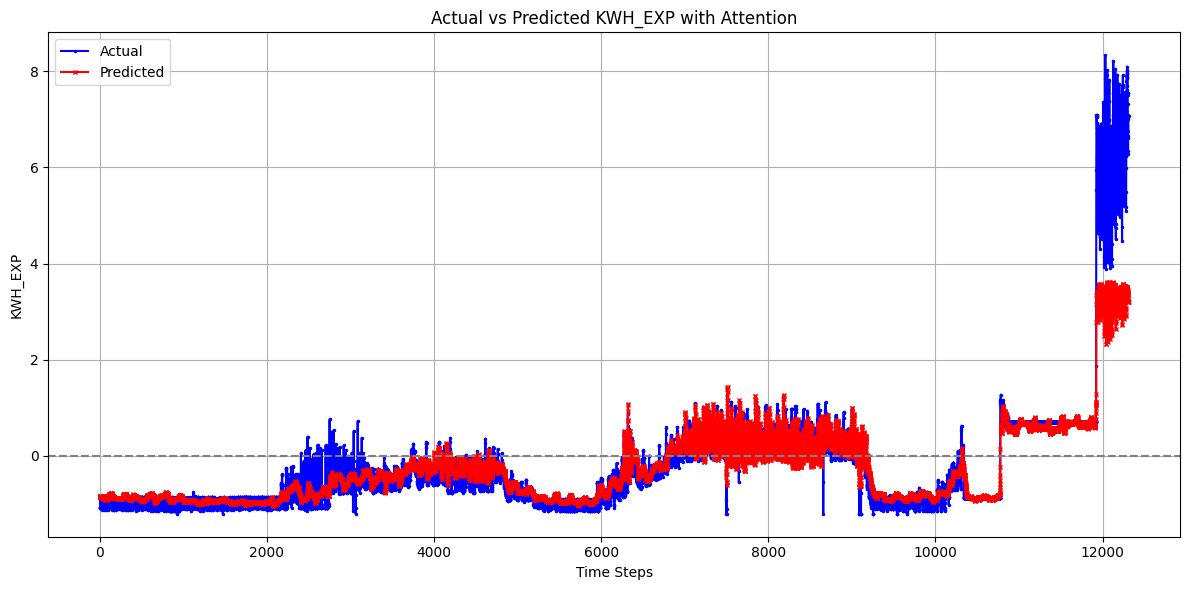

In [75]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with Attention')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [76]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.3520468895913838
MAE: 0.22613417886451084
R²: 0.8060205236432708
MAPE: 2.4316135697618715


BILSTM ATTENTION

In [77]:
# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        attention_weights = tf.nn.softmax(tf.matmul(inputs, inputs, transpose_b=True), axis=-1)
        context_vector = tf.matmul(attention_weights, inputs)
        return context_vector

# Model definition with Attention
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)
x = Bidirectional(LSTM(units=128, return_sequences=True))(inputs)
x = AttentionLayer()(x)
x = Bidirectional(LSTM(units=64, return_sequences=False))(x)
outputs = Dense(units=1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 96, 56)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 96, 256)             │         189,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_5 (AttentionLayer)   │ (None, 96, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 353,921 (1.35 MB)

 Trainable params: 353,921 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - loss: 0.5505 - val_loss: 0.2422 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.6784 - val_loss: 0.1951 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.3209 - val_loss: 0.1343 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.2835 - val_loss: 0.0940 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.3427 - val_loss: 0.0684 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.2089 - val_loss: 0.0743 - learning_rate: 9.0484e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.1453 - val_loss: 0.0625 - learning_rate: 8.1873e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.1384 - val_loss: 0.0578 - learning_rate: 7.4082e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.1018 - val_loss: 0.0530 - learning_rate: 6.703

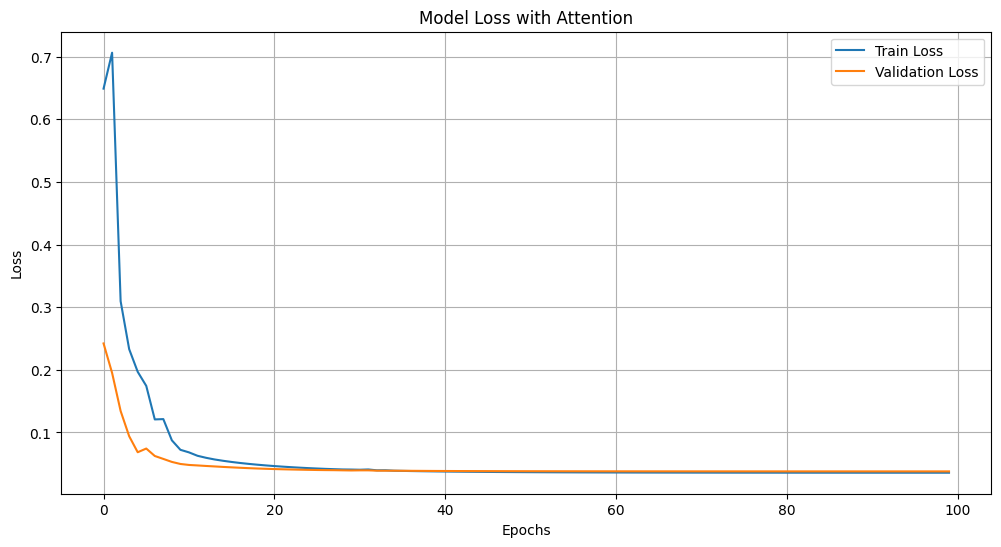

385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [78]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

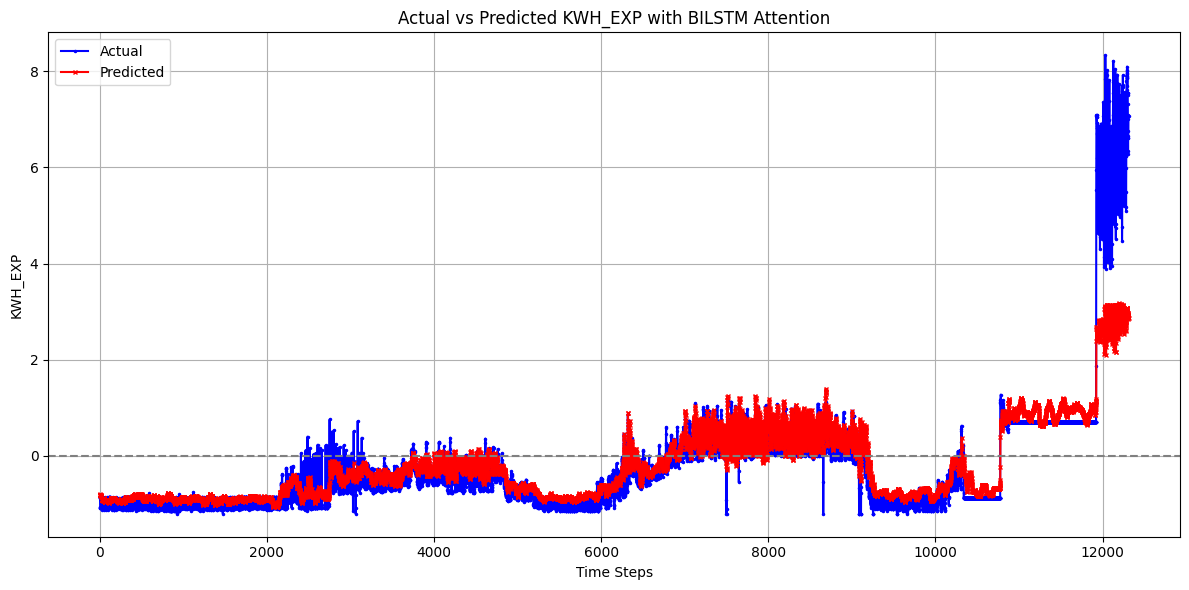

In [79]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with BILSTM Attention')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [80]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.4623890796810388
MAE: 0.2669495749896416
R²: 0.745221462817909
MAPE: 2.3292863748872548


# LSTM

In [81]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=1))

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 96, 56)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 96, 256)             │         189,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_5 (AttentionLayer)   │ (None, 96, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 353,921 (1.35 MB)

 Trainable params: 353,921 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - loss: 0.0836 - val_loss: 0.3474 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.2121 - val_loss: 0.1000 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.2436 - val_loss: 0.1108 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.1214 - val_loss: 0.0608 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.2165 - val_loss: 0.0559 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.1887 - val_loss: 0.0621 - learning_rate: 9.0484e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.1197 - val_loss: 0.0498 - learning_rate: 8.1873e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.1081 - val_loss: 0.0422 - learning_rate: 7.4082e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0773 - val_loss: 0.0421 - learning_rate: 6.703

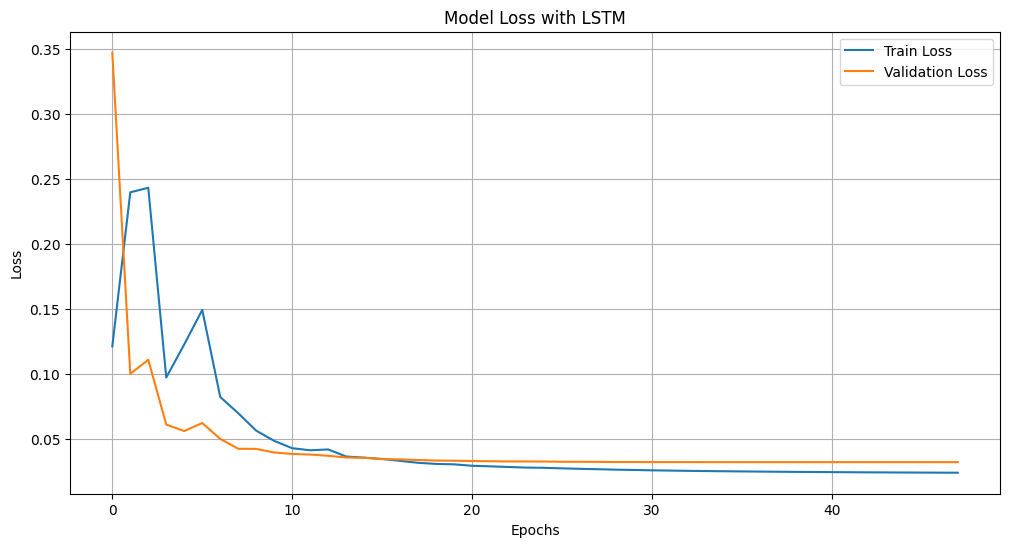

385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [82]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

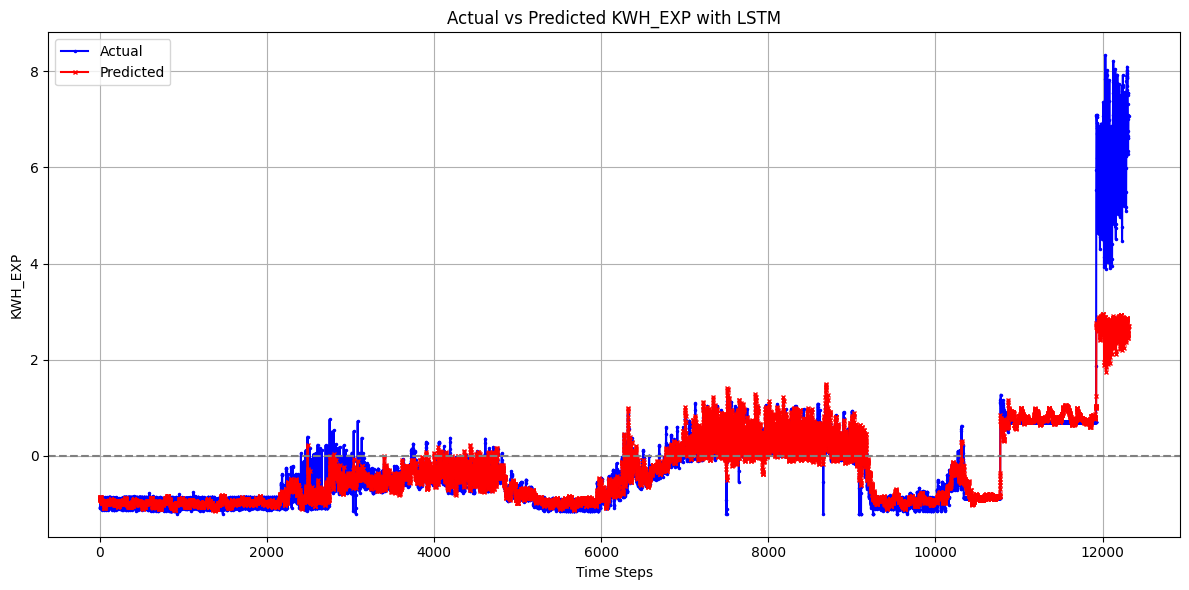

In [83]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with LSTM')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [84]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.481586642388621
MAE: 0.22106879820932882
R²: 0.7346435163242913
MAPE: 1.3060671536635011
